```bash
export TASK_QUEUE_ENABLE="2"
export CPU_AFFINITY_CONF="2"
export HCCL_OP_EXPANSION_MODE="AIV"
export HCCL_DETERMINISTIC="false"
export PYTORCH_NPU_ALLOC_CONF="expandable_segments:True"
export INF_NAN_MODE_FORCE_DISABLE="1"
```

## Download

In [ ]:
import os

os.environ["MODELSCOPE_CACHE"] = "weights"

In [ ]:
# SDK模型下载
from modelscope import snapshot_download

snapshot_download('iic/CosyVoice2-0.5B', local_dir='pretrained_models/CosyVoice2-0.5B')
# snapshot_download('iic/CosyVoice-ttsfrd', local_dir='pretrained_models/CosyVoice-ttsfrd')
# snapshot_download("pengzhendong/wetext", local_dir='pretrained_models/wetext')
"snapshot_download done"

## Ready

In [ ]:
import sys

sys.path.append("third_party/Matcha-TTS")
sys.path.append("third_party/async_cosyvoice")
sys.path.append("third_party/vllm")

In [ ]:
from pathlib import Path

Path("./output").mkdir(exist_ok=True)

## Torch inference

In [ ]:
import torchaudio

from cosyvoice.cli.cosyvoice import CosyVoice2
from cosyvoice.utils.file_utils import load_wav

In [ ]:
cosyvoice = CosyVoice2(
    "pretrained_models/CosyVoice2-0.5B",
    load_jit=True,
    load_trt=False,
    load_vllm=False,
    fp16=True,
)

In [ ]:
# NOTE if you want to reproduce the results on https://funaudiollm.github.io/cosyvoice2,
# please add text_frontend=False during inference
prompt_speech_16k = load_wav("./asset/zero_shot_prompt.wav", 16000)

In [ ]:
print(cosyvoice.list_available_spks())

In [ ]:
# wget https://www.modelscope.cn/models/iic/CosyVoice-300M-SFT/resolve/master/spk2info.pt
# 不支持流式，且输出有问题
for i, j in enumerate(
    cosyvoice.inference_sft(
        "收到好友从远方寄来的生日礼物，那份意外的惊喜和深深的祝福，让我心中充满了甜蜜的快乐，笑容如花儿般绽放。",
        "英文男",
        stream=False,
    )
):
    torchaudio.save("output/inference_sft_{}.wav".format(i), j["tts_speech"], cosyvoice.sample_rate)


In [ ]:
for i, j in enumerate(
    cosyvoice.inference_zero_shot(
        "收到好友从远方寄来的生日礼物，那份意外的惊喜与深深的祝福，让我心中充满了甜蜜的快乐，笑容如花儿般绽放。",
        "希望你以后能够做的比我还好呦。",
        prompt_speech_16k,
        stream=False,
    )
):
    torchaudio.save("output/zero_shot_{}.wav".format(i), j["tts_speech"], cosyvoice.sample_rate)

In [ ]:
# save zero_shot spk for future usage
assert (
    cosyvoice.add_zero_shot_spk(
        "希望你以后能够做的比我还好呦。", prompt_speech_16k, "my_zero_shot_spk"
    )
    is True
)

In [ ]:
for i, j in enumerate(
    cosyvoice.inference_zero_shot(
        "收到好友从远方寄来的生日礼物，那份意外的惊喜与深深的祝福,让我心中充满了甜蜜的快乐，笑容如花儿般绽放。",
        "",
        "",
        zero_shot_spk_id="my_zero_shot_spk",
        stream=False,
    )
):
    torchaudio.save("output/zero_shot_{}.wav".format(i), j["tts_speech"], cosyvoice.sample_rate)
#cosyvoice.save_spkinfo()

In [ ]:
# fine grained control, for supported control, check cosyvoice/tokenizer/tokenizer.py#L248
for i, j in enumerate(
    cosyvoice.inference_cross_lingual(
        "在他讲述那个荒诞故事的过程中，他突然[laughter]停下来，因为他自己也被逗笑了[laughter]。",
        prompt_speech_16k,
        stream=False,
    )
):
    torchaudio.save("output/fine_grained_control_{}.wav".format(i), j["tts_speech"], cosyvoice.sample_rate)

In [ ]:
# instruct usage，河南话不行，广东话还行
for i, j in enumerate(
    cosyvoice.inference_instruct2(
        "收到好友从远那份意外的惊喜与深深的祝福让我心中充满了甜蜜的快乐，笑容如花儿般绽放。",
        "用河南话说这句话",
        prompt_speech_16k,
        stream=False,
    )
):
    torchaudio.save("output/instruct_{}.wav".format(i), j["tts_speech"], cosyvoice.sample_rate)

In [ ]:
# bistream usage, you can use generator as input, this is useful when using text llm model as input
# NOTE you should still have some basic sentence split logic because llm can not handle arbitrary sentence length
def text_generator():
    yield "收到好友从远方寄来的生日礼物，"
    yield "那份意外的惊喜与深深的祝福"
    yield "让我心中充满了甜蜜的快乐，"
    yield "笑容如花儿般绽放。"

for i, j in enumerate(
    cosyvoice.inference_zero_shot(
        text_generator(), "希望你以后能够做的比我还好呦。", prompt_speech_16k, stream=False
    )
):
    torchaudio.save("output/zero_shot_{}.wav".format(i), j["tts_speech"], cosyvoice.sample_rate)

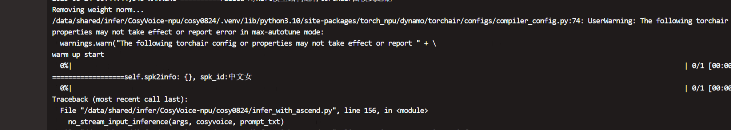

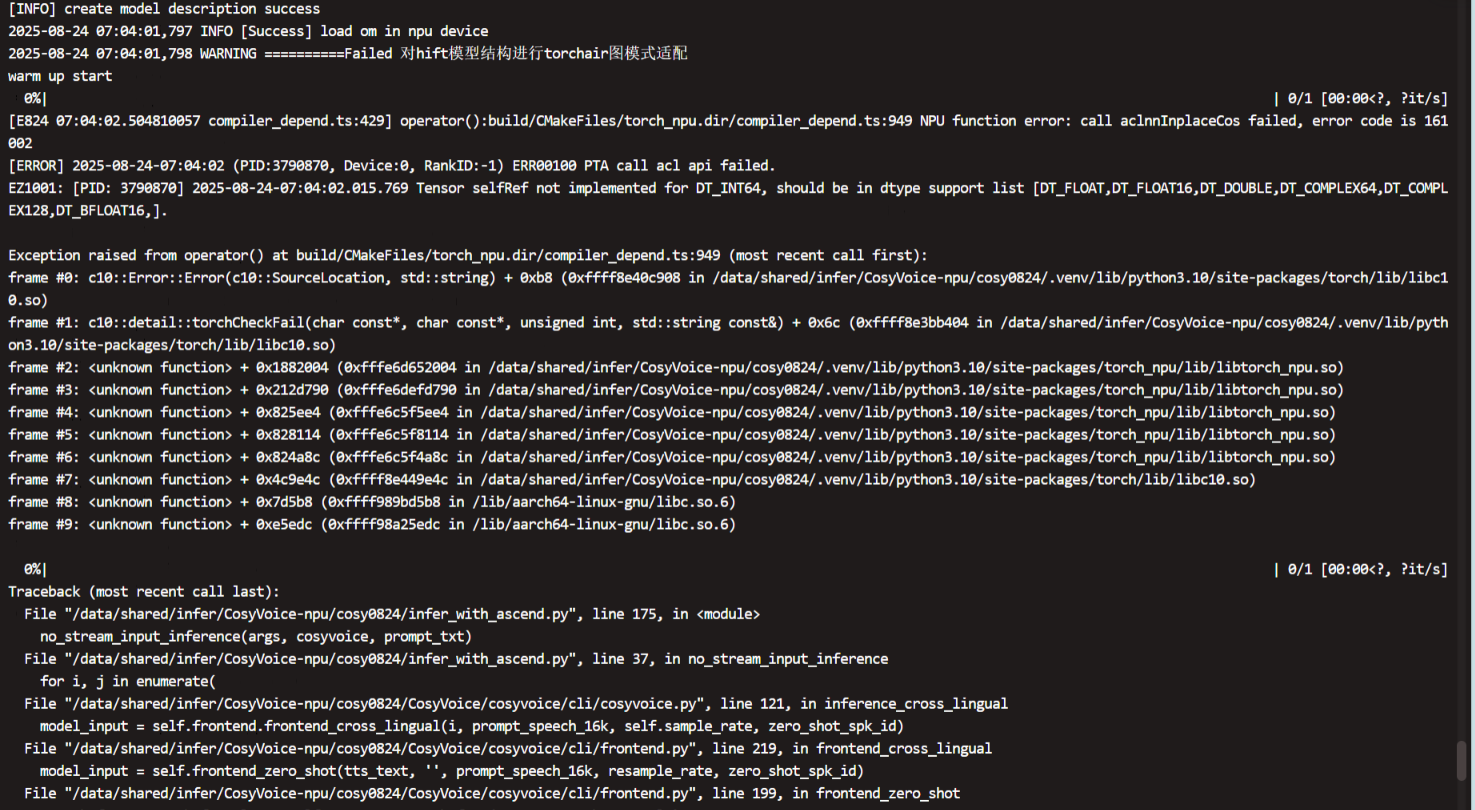
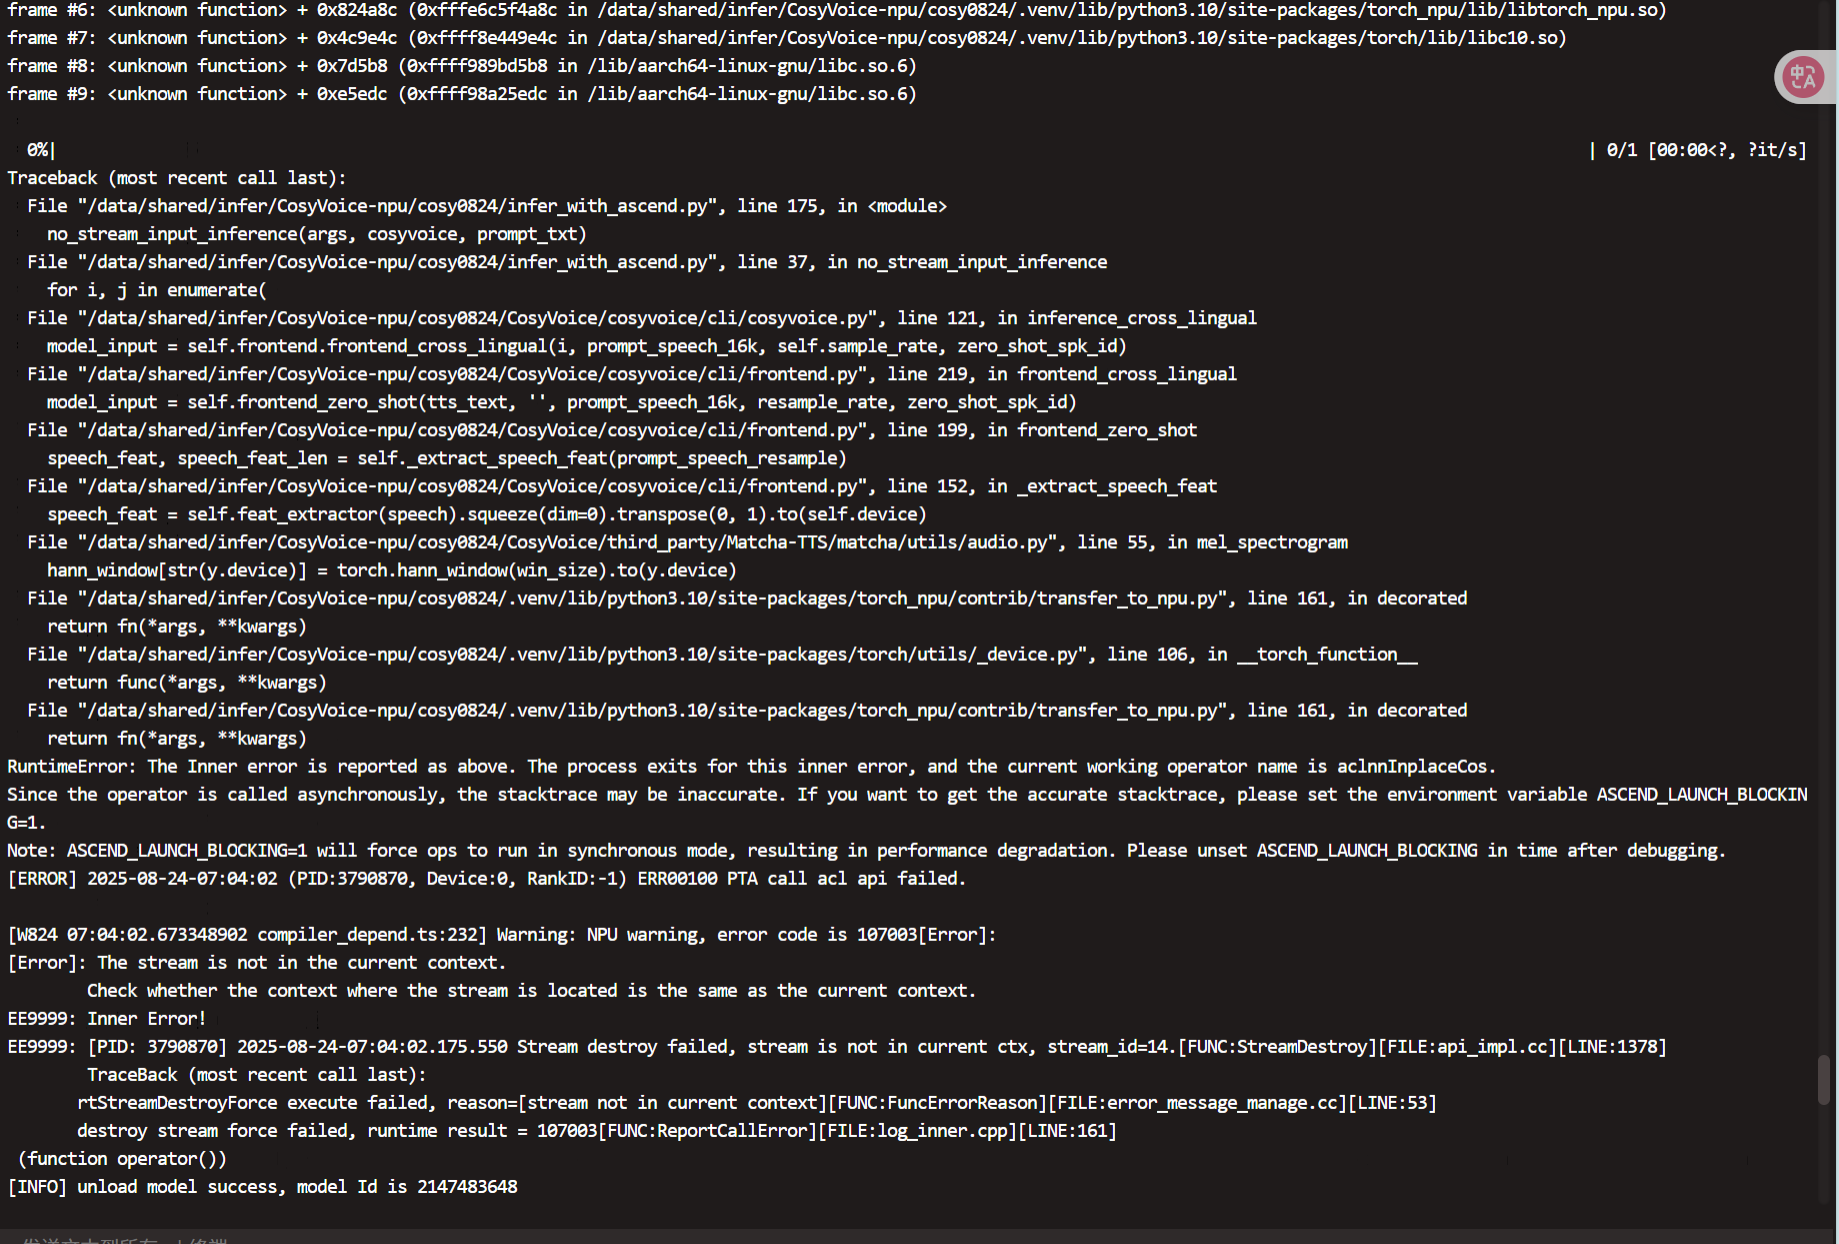

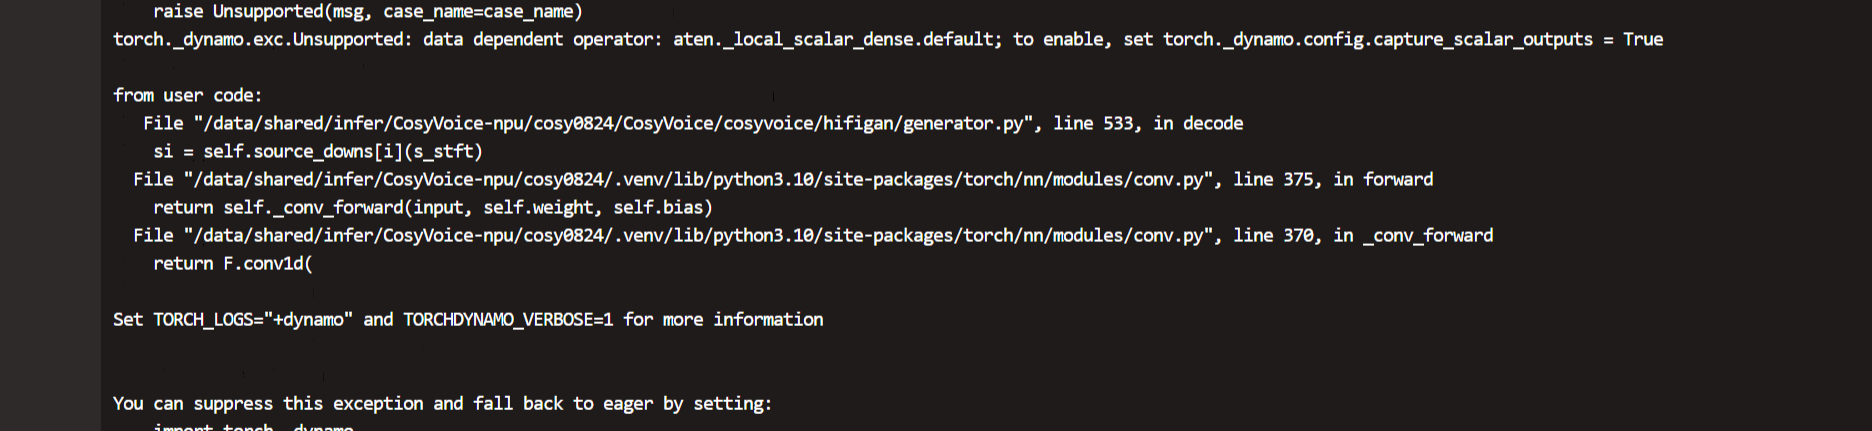

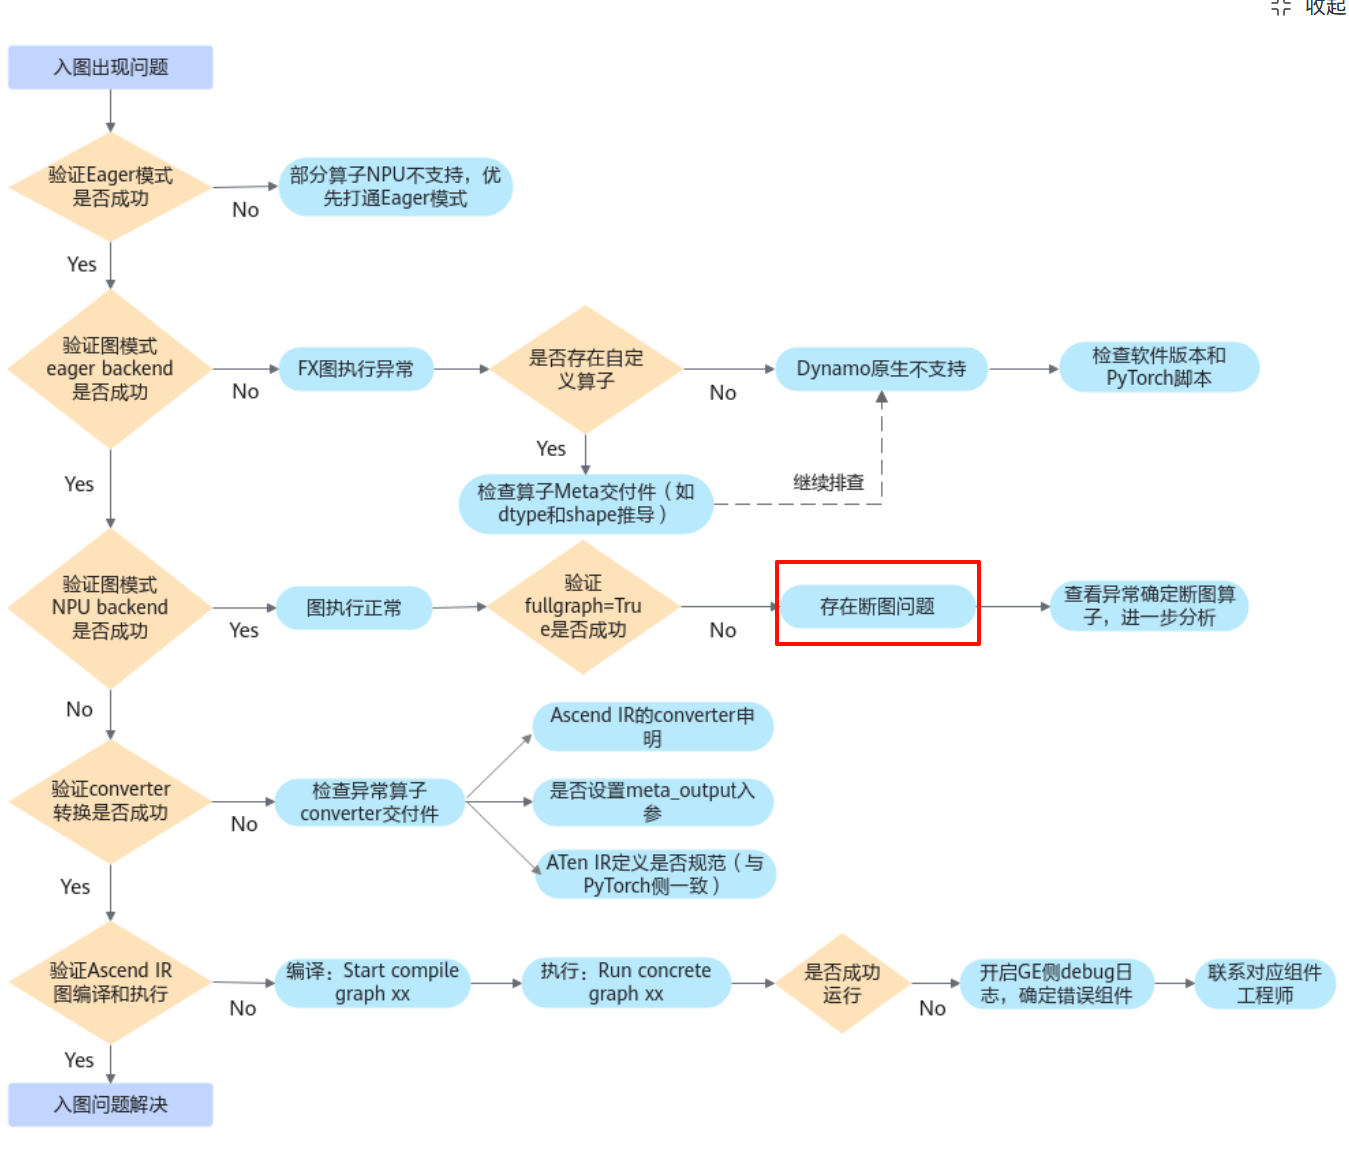

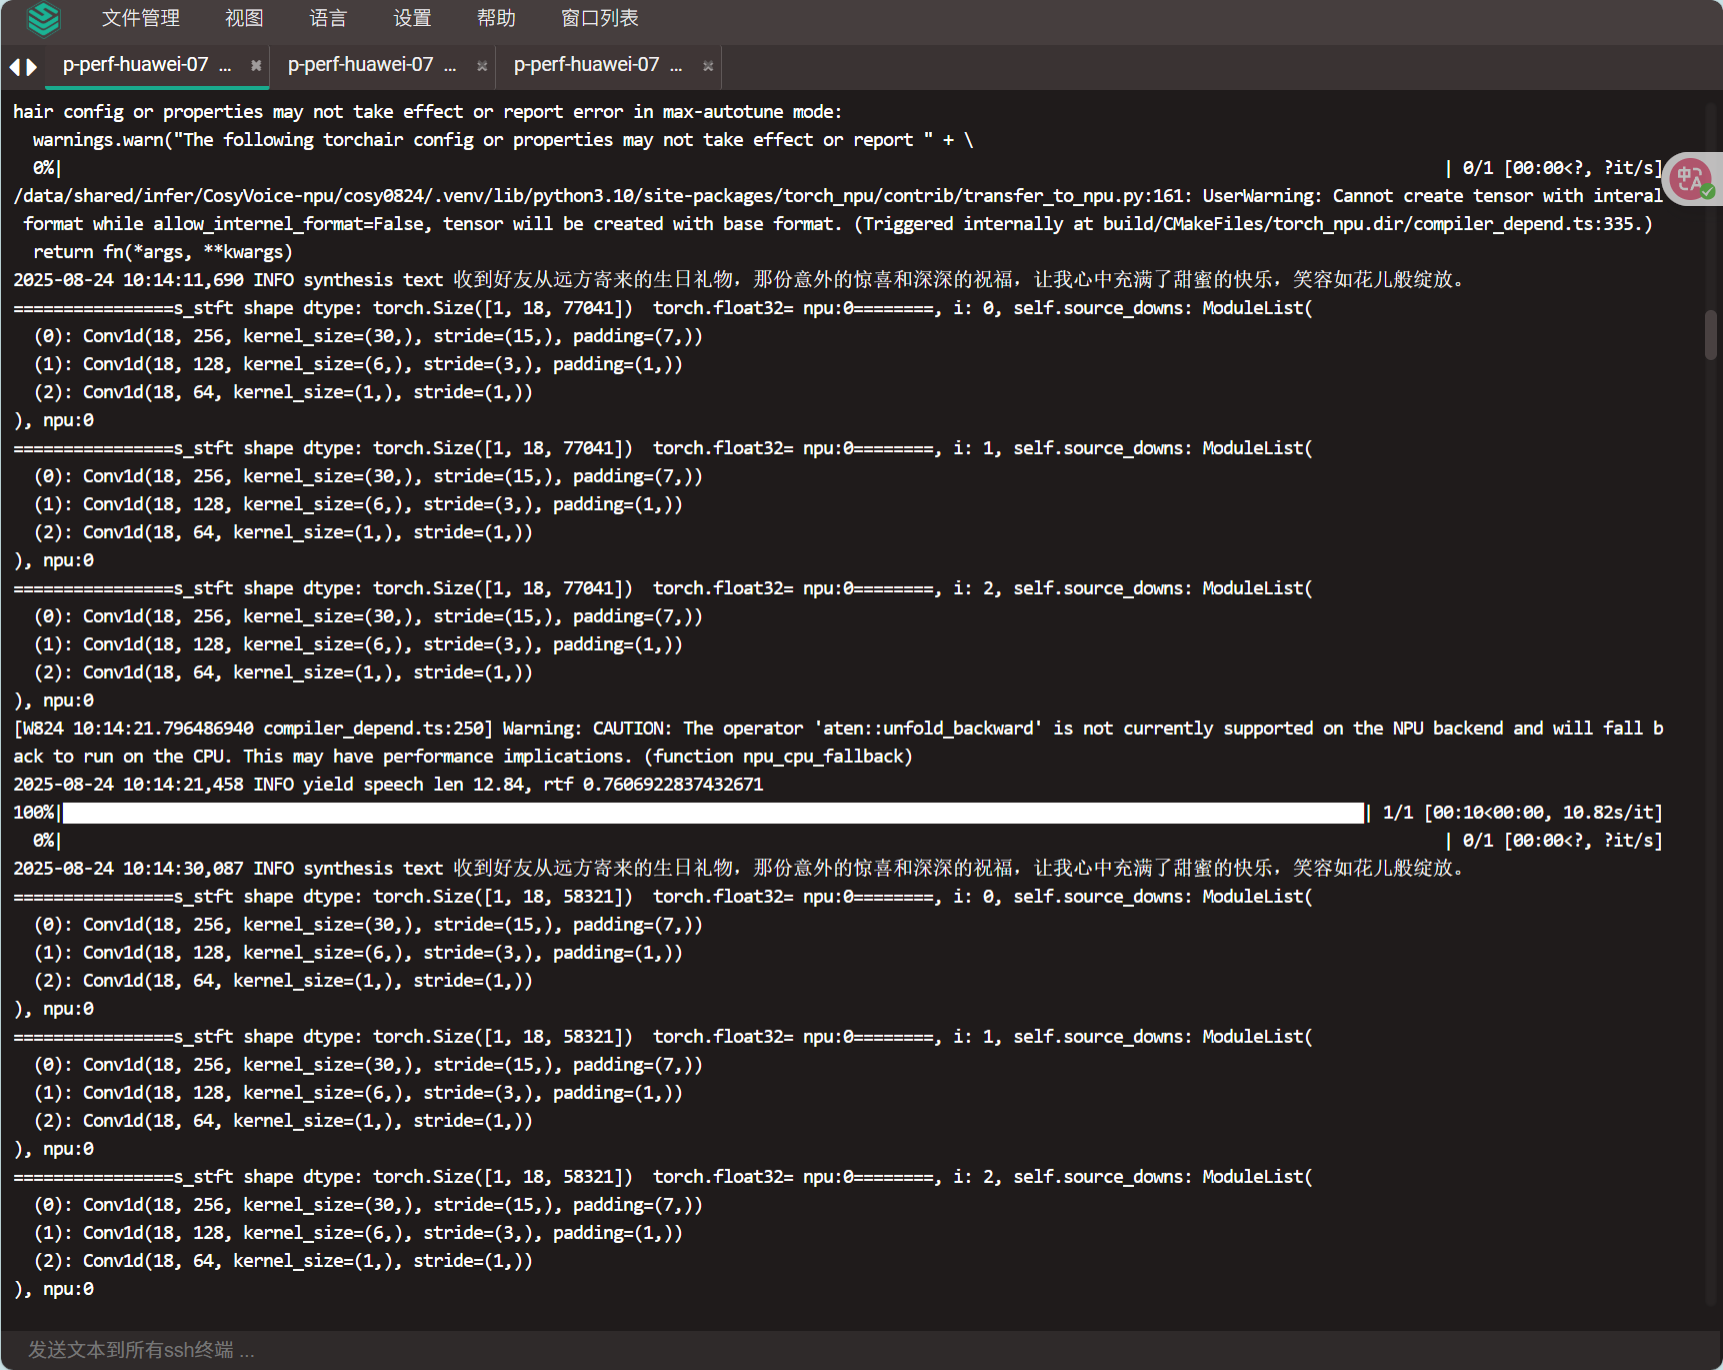